# Finetuning Notebook: Adapt Silhouette-Trained CNN+Transformer model to Dot Dataset


**Objective:**
This notebook loads the NumerosityCNNTransformer model previously trained on silhouette-based (MPEG7) images and fine-tunes it using dot pattern data.

Steps:
1. Load dot pattern dataset (train/val/test splits).
2. Load the pretrained silhouette-based model weights.
3. Fine-tune the model on dot data.
4. Evaluate performance (loss, accuracy, confusion matrix).
5. Visualize sample predictions.


# Import Libraries and Setup Device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set Seed for Reproducibility

In [2]:
# Set reproducibility seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Load Dataset

In [4]:
from torch.utils.data import Dataset

class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        num_dots = random.randint(1, 30)
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        img = torch.tensor(img).unsqueeze(0) / 255.0
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [5]:
# Load dot datasets
train_dataset = torch.load("train_dataset.pt", weights_only=False)
val_dataset = torch.load("val_dataset.pt", weights_only=False)
test_dataset = torch.load("test_dataset.pt", weights_only=False)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 3500
Validation Dataset Size: 750
Test Dataset Size: 750


# Define the Model Architecture

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class NumerosityCNNTransformer(nn.Module):
    def __init__(self, image_size=128, patch_size=4, embed_dim=128, num_heads=4, num_layers=2, num_classes=3):
        super(NumerosityCNNTransformer, self).__init__()

        # CNN Backbone with Residual Blocks
        self.cnn_layers = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2),
            ResidualBlock(32, 64),
            nn.MaxPool2d(2),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )

        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (16 // patch_size) ** 2

        # Patch embedding using convolution
        self.patch_embedding = nn.Conv2d(128, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regularization & Classification Head
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        out = self.cnn_layers(x)

        # Convert CNN features into patches
        patches = self.patch_embedding(out)
        patches = patches.flatten(2).transpose(1, 2)

        # Add positional encoding
        patches += self.pos_embedding

        # Transformer processing
        transformer_out = self.transformer_encoder(patches)

        # Pooled output & classification
        pooled_out = transformer_out.mean(dim=1)
        pooled_out = self.layer_norm(pooled_out)
        pooled_out = self.dropout(pooled_out)

        return self.fc(pooled_out)

# Load the Pre-Trained Model

## Load the pre-trained model from the saved checkpoint "final_numerosity_model.pt".

In [7]:
model = NumerosityCNNTransformer().to(device)
model.load_state_dict(torch.load("final_numerosity_model.pt", map_location=device))
model.eval()
print("Pre-trained model loaded successfully.")

Pre-trained model loaded successfully.


# Training and Evaluation Functions

In [8]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return running_loss / len(loader), acc, all_preds, all_labels

# Finetuning Loop

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 25
early_stop_patience=3

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    best_val_loss = float('inf')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

Epoch [1/25], Train Loss: 0.4787, Val Loss: 1.2150, Val Acc: 57.20%
Epoch [2/25], Train Loss: 0.2463, Val Loss: 0.2306, Val Acc: 90.53%
Epoch [3/25], Train Loss: 0.2106, Val Loss: 0.2096, Val Acc: 91.20%
Epoch [4/25], Train Loss: 0.1915, Val Loss: 0.1992, Val Acc: 92.13%
Epoch [5/25], Train Loss: 0.1733, Val Loss: 0.1990, Val Acc: 91.33%
Epoch [6/25], Train Loss: 0.1746, Val Loss: 0.1842, Val Acc: 91.73%
Epoch [7/25], Train Loss: 0.1507, Val Loss: 0.1726, Val Acc: 92.53%
Epoch [8/25], Train Loss: 0.1414, Val Loss: 0.1782, Val Acc: 92.00%
Epoch [9/25], Train Loss: 0.1204, Val Loss: 0.1638, Val Acc: 93.20%
Epoch [10/25], Train Loss: 0.1226, Val Loss: 0.1627, Val Acc: 93.07%
Epoch [11/25], Train Loss: 0.1118, Val Loss: 0.2399, Val Acc: 90.13%
Epoch [12/25], Train Loss: 0.1365, Val Loss: 0.1649, Val Acc: 92.00%
Epoch [13/25], Train Loss: 0.0859, Val Loss: 0.1651, Val Acc: 91.87%
Epoch [14/25], Train Loss: 0.0906, Val Loss: 0.2427, Val Acc: 89.87%
Epoch [15/25], Train Loss: 0.1148, Val Loss

# Evaluation of Test set & visualization

In [10]:
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.2981, Test Accuracy: 92.53%


In [11]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=["Few", "Medium", "Many"]))


Classification Report:
              precision    recall  f1-score   support

         Few       0.91      0.98      0.94       122
      Medium       0.94      0.85      0.89       277
        Many       0.92      0.97      0.94       351

    accuracy                           0.93       750
   macro avg       0.92      0.93      0.93       750
weighted avg       0.93      0.93      0.92       750



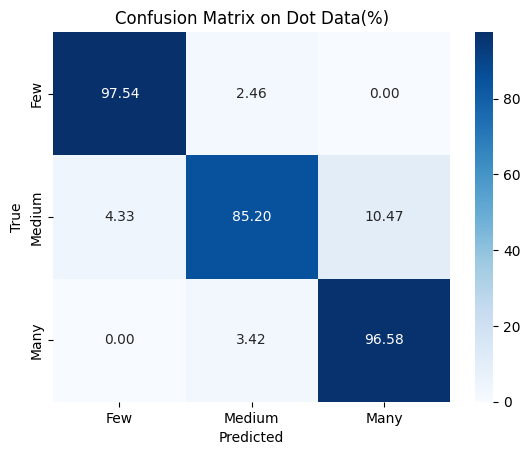

In [18]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=["Few", "Medium", "Many"], yticklabels=["Few", "Medium", "Many"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Dot Data(%)")
plt.show()



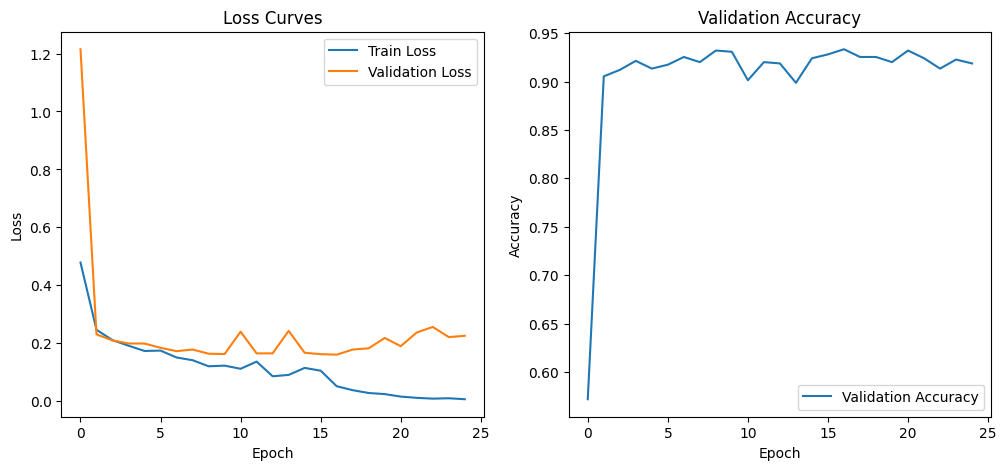

In [19]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Visualize Test Images with Predictions

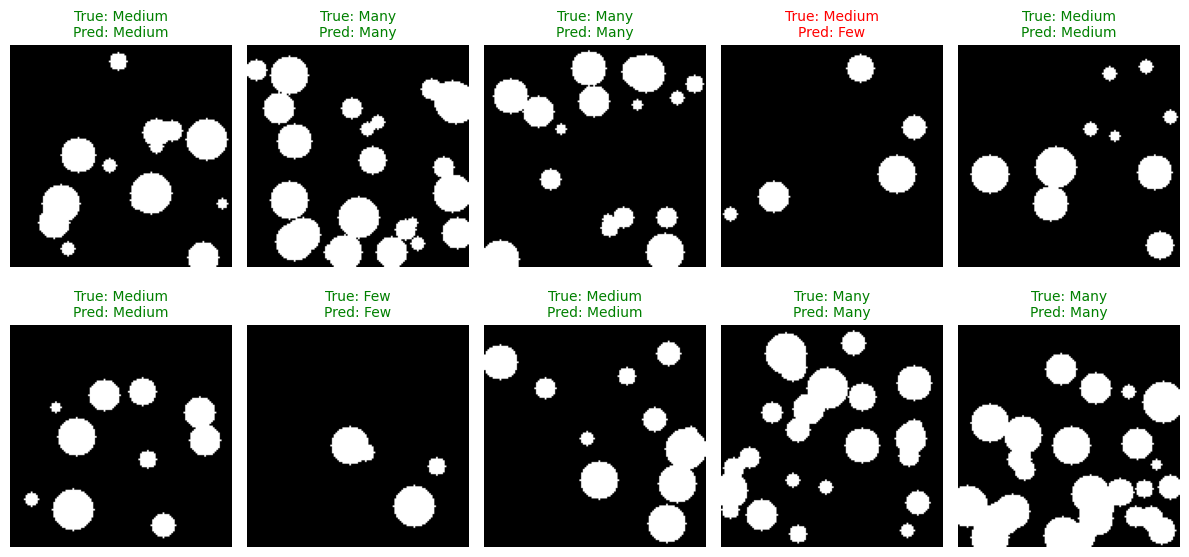

In [14]:
# Get a batch of test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Map numeric labels to class names
label_names = {0: "Few", 1: "Medium", 2: "Many"}

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):  # Show 10 sample test images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    true_label = label_names[labels[i].item()]
    pred_label = label_names[predicted[i].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()